# Skip-gram with Negative Sampling

Here, I train three SGNS models on a corpus of differing size (1 MB, 10 MB, and 50 MB) loaded from [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py). 

This work is meant to replicate [Mimno & Thompson (2017)](https://aclanthology.org/D17-1308.pdf), who use inner products between embeddings to show that the distribution of learned embeddings is influenced by the number of negative samples, and the frequency, of word embeddings. 

In [189]:
%reset

import gensim
import io
import os
import smart_open

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from gensim import utils
from gensim.test.utils import datapath
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Define Custom Functions & Classes

In [190]:
## Define Functions to Compute IsoScore
## Rudman et al. 2022
## TODO: make this a class

## Step 2
def pca_normalization(points):
    """points: (m samples x n dimensions)"""
    
    pca = PCA(n_components=len(np.transpose(points)))
    points = pca.fit_transform(points)

    return np.transpose(points)

## Step 3
def get_diag_of_cov(points):
    """points: (n dims x m samples)"""
    
    n = np.shape(points)[0]
    cov = np.cov(points)
    cov_diag = cov[np.diag_indices(n)]

    return cov_diag

## Step 4
def normalize_diagonal(cov_diag):

    n = len(cov_diag)
    cov_diag_normalized = (cov_diag*np.sqrt(n))/np.linalg.norm(cov_diag)

    return cov_diag_normalized

## Step 5
def get_isotropy_defect(cov_diag_normalized):

    n = len(cov_diag_normalized)
    iso_diag = np.eye(n)[np.diag_indices(n)]
    l2_norm = np.linalg.norm(cov_diag_normalized - iso_diag)
    normalization_constant = np.sqrt(2*(n-np.sqrt(n)))
    isotropy_defect = l2_norm/normalization_constant

    return isotropy_defect

## Interlude
def get_kdims(isotropy_defect, points): 
    
    n = np.shape(points)[0]
    k = ((n-(isotropy_defect**2)*(n-np.sqrt(n)))**2) / n
    
    return k

def get_fraction_dims(k, points):
    
    n = np.shape(points)[0]
    phi = k/n
    
    return phi

## Step 6
def get_IsoScore(isotropy_defect, points):

    n = np.shape(points)[0]
    the_score = ((n-(isotropy_defect**2)*(n-np.sqrt(n)))**2-n)/(n*(n-1))

    return the_score


### Define dataset class

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

### Define functions from 
## Radim Hurek
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

def head(path, size):
    with smart_open.open(path) as fin:
        return io.StringIO(fin.read(size))
    
def generate_input_data():
    
    labels = ('1MB', '10MB', '50MB', '100MB')
    sizes = (1024 ** 2, 10 * 1024 ** 2, 50 * 1024 ** 2, 100 * 1024 ** 2)
    for l, s in zip(labels, sizes):
        ls = gensim.models.word2vec.LineSentence(head(text8_path, s))
        ls.name = l
        yield ls

### Define your corpus

In [191]:
## from Gensim
text8_path = api.load('text8').fn

input_data = list(generate_input_data())
input_data[-1].name

'100MB'

### Vary number of negative samples

In [192]:
# param sets from Mimno & Thompson (2017)

negsamps = np.linspace(1,15,15)
window_size = 5
embedding_dim = 50

In [194]:
d = []

for data in tqdm(input_data, colour="hotpink"): 
    
    for n in tqdm(negsamps, colour="cornflowerblue"):

        for rs in range(1, 3):

            # Train an sgns model with these params
            model = gensim.models.Word2Vec(sentences=data,
                                           negative=n, 
                                           window=window_size,
                                           vector_size=embedding_dim,
                                           seed = rs
                                          )

            # Grab the dataset size, will be a string
            data_sizestr = data.name


            # Visualize pca-transformed embeddings per model
            V = []
            for ix, word in enumerate(model.wv.index_to_key):

                V.append(model.wv[word])

#             pca = PCA(n_components=3)
#             V_pca = pca.fit_transform(V)


#             # Create a 3D surface plot using Matplotlib
#             fig = plt.figure(figsize=(2,2))
#             ax = fig.add_subplot(111, projection='3d')
#             ax.scatter(V_pca[:,0], V_pca[:,1], V_pca[:,2])

#             # Customize the plot using Seaborn's styling options
#             sns.set_style("whitegrid")
#             ax.set_xlabel('dim1')
#             ax.set_ylabel('dim2')
#             ax.set_zlabel('dim3')
#             ax.set_title(f"{n} negative samples")

            # Compute isoscore on embedding matrix
            pca_layer_embed = pca_normalization(V)
            cov_diag = get_diag_of_cov(pca_layer_embed)
            cov_diag_normalized = normalize_diagonal(cov_diag)
            isotropy_defect = get_isotropy_defect(cov_diag_normalized)
            k = get_kdims(isotropy_defect, pca_layer_embed)
            phi = get_fraction_dims(k, pca_layer_embed)
            isoscore = get_IsoScore(isotropy_defect, pca_layer_embed)

            d.append({"n_negsamps": n,
                      "window_size": window_size,
                      "embedding_dim": embedding_dim,
                      "kdims": k,
                      "isoscore": isoscore,
                      'rs': rs,
                      "train_data_size": data_sizestr
                     })

df = pd.DataFrame(d)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [196]:
df["corpus"] = np.repeat("text8-gensim",df.shape[0])

In [198]:
df["model"] = np.repeat("sgns",df.shape[0])


,n_negsamps,window_size,embedding_dim,kdims,isoscore,rs,train_data_size,corpus,model
0,1.0,5,50,1.353451,0.007213,1,1MB,text8-gensim,sgns
1,1.0,5,50,1.353619,0.007217,2,1MB,text8-gensim,sgns
2,2.0,5,50,1.832325,0.016986,1,1MB,text8-gensim,sgns
3,2.0,5,50,1.839020,0.017123,2,1MB,text8-gensim,sgns
4,3.0,5,50,1.664990,0.013571,1,1MB,text8-gensim,sgns
...,...,...,...,...,...,...,...,...,...
115,13.0,5,50,24.471030,0.479001,2,100MB,text8-gensim,sgns
116,14.0,5,50,24.597348,0.481579,1,100MB,text8-gensim,sgns
117,14.0,5,50,24.630978,0.482265,2,100MB,text8-gensim,sgns
118,15.0,5,50,24.665673,0.482973,1,100MB,text8-gensim,sgns


In [199]:
savepath = "results/"
if not os.path.exists(savepath): 
    os.mkdir(savepath)
    
df.to_csv(os.path.join(savepath,"sgns-vary-negsamps-meas-isotropy.csv"))

In [202]:
df.columns

Index(['n_negsamps', 'window_size', 'embedding_dim', 'kdims', 'isoscore', 'rs',
       'train_data_size', 'corpus', 'model'],
      dtype='object')

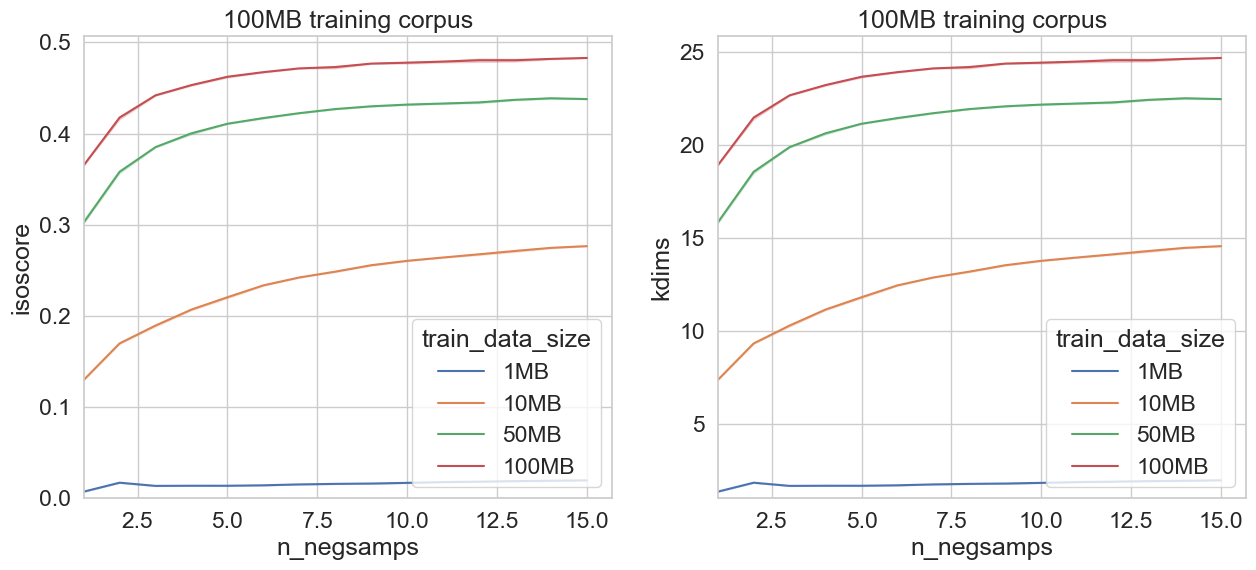

In [205]:
sns.set(font_scale=1.5,style="whitegrid")
fig,ax = plt.subplots(1,2,figsize=(15,6))

sns.lineplot(data=df,
             x="n_negsamps",
             y="isoscore",
             hue="train_data_size",
             ax=ax[0]
            )
ax[0].set_ylim(0,)

sns.lineplot(data=df,
             x="n_negsamps",
             y="kdims",
             hue="train_data_size",
              ax=ax[1]
            )
ax[1].set_ylim(1,)

for a in ax:
    a.set_xlim(1,)
    a.set_title(f"{data_sizestr} training corpus")

### compare to average cosine similarity results -- opposite to Mimno & Thompson 2017?